### 1. Generate foggy datasets


Import libraries

In [ ]:
import cv2
import torch
import matplotlib.pyplot as plt

from depth_anything_v2.dpt import DepthAnythingV2

xFormers not available
xFormers not available


Estimate depth image

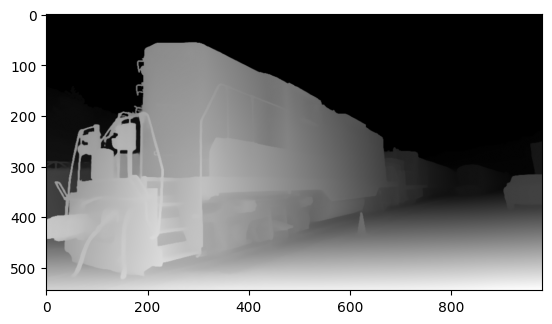

In [15]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

encoder = 'vitl' # or 'vits', 'vitb', 'vitg'

model = DepthAnythingV2(**model_configs[encoder])
model.load_state_dict(torch.load(f'/home/tsy/Documents/TeamM_Defog/references/Depth-Anything-V2/pretrained/depth_anything_v2_{encoder}.pth', map_location=DEVICE))
model = model.to(DEVICE).eval()

raw_img = cv2.imread('/home/tsy/Documents/TeamM_Defog/datasets/tandt_db/tandt/train/images/00001.jpg') # HxWx3 numpy array
depth = model.infer_image(raw_img) # HxW raw depth map in numpy

plt.imshow(depth, cmap="gray")

霧あり画像の生成

In [5]:
# !pip install ipywidgets > /dev/null 2>&1

import cv2
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display

np.random.seed(42)

In [6]:
# 霧を生成する関数
def asm_fog_basic(image, depth, beta=0.05, A=1.0):
    """
    霧のある画像を生成する
    :param image: 入力画像（理想的な画像）
    :param depth: 深度画像
    :param beta: 霧の濃さ（透過率に影響）
    :param A: 大気光の強度
    :return: 霧のある画像
    """
    # 画像サイズを取得
    h, w, _ = image.shape

    # 透過率 t(x) を計算
    depth = 1.0 - depth.mean(axis=2, keepdims=True) / depth.max()
    t = np.exp(-beta * depth)

    # 霧のある画像を生成
    foggy_image = image * t + A * (1 - t)

    # ピクセル値を0-255にクリップして整数型に変換
    foggy_image = foggy_image.astype(np.uint8)
    foggy_image = np.clip(foggy_image, 0, 255)

    return A*(1-t), foggy_image


# 霧を生成する関数
def asm_fog_noise(image, depth, beta=0.05, A=1.0):
    """
    霧のある画像を生成する
    :param image: 入力画像（理想的な画像）
    :param depth: 深度画像
    :param beta: 霧の濃さ（透過率に影響）
    :param A: 大気光の強度
    :return: 霧のある画像
    """
    # 画像サイズを取得
    h, w, c = image.shape

    # 透過率 t(x) を計算
    depth = 1.0 - depth.mean(axis=2, keepdims=True) / depth.max()
    t = np.exp(-beta * depth)

    # 霧のある画像を生成
    noise = 1 + 0.1*np.random.rand(h, w, c)
    foggy_image = image * t + A * (1 - t) * noise

    # ピクセル値を0-255にクリップして整数型に変換
    foggy_image = foggy_image.astype(np.uint8)
    foggy_image = np.clip(foggy_image, 0, 255)

    return A*(1-t), foggy_image


# 霧を生成する関数
def asm_fog_mask(image, depth, beta=0.05, A=1.0):
    """
    霧のある画像を生成する
    :param image: 入力画像（理想的な画像）
    :param depth: 深度画像
    :param beta: 霧の濃さ（透過率に影響）
    :param A: 大気光の強度
    :return: 霧のある画像
    """
    # 画像サイズを取得
    h, w, c = image.shape

    # 透過率 t(x) を計算
    depth = 1.0 - depth.mean(axis=2, keepdims=True) / depth.max()
    t = np.exp(-beta * depth)

    # mask を定義
    mask = np.ones((h, w, 1))
    i_values = np.arange(50)  # Create an array of i values from 0 to 9
    thresholds = 0.95 - 0.005 * i_values  # Compute the thresholds for all i values
    values = 1 - 0.02 * i_values  # Compute the corresponding mask values for all i values

    for threshold, value in zip(thresholds, values):
        mask[depth < threshold] = value

    # 霧のある画像を生成
    foggy_image = image * (1 - mask) + (image * t + A * (1 - t)) * mask

    # ピクセル値を0-255にクリップして整数型に変換
    foggy_image = foggy_image.astype(np.uint8)
    foggy_image = np.clip(foggy_image, 0, 255)

    return A*(1-t), foggy_image

In [7]:
# 霧除去アルゴリズム
def dehaze_image_CLAHE(image, clipLimit=6.0, tileGridSize=4):
    # Convert image to array and apply dehazing using simple contrast enhancement as a placeholder
    image_np = np.array(image)

    # Using OpenCV's dehazing method as a simple approach (CLAHE - Contrast Limited Adaptive Histogram Equalization)
    lab = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=(tileGridSize, tileGridSize))
    cl = clahe.apply(l)

    # Merge the channels back
    limg = cv2.merge((cl,a,b))

    # Convert LAB back to RGB
    image_dehazed = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    return image_dehazed

# Test Running Duration
# image = cv2.cvtColor(cv2.imread('/content/1403638127245096960.png'), cv2.COLOR_BGR2RGB)
# %timeit dehaze_image_CLAHE(image)

In [16]:
# 入力画像を読み込み（https://diode-dataset.org/）
# raw_img = cv2.imread('/content/1403638127245096960.png')
image = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
depth = np.expand_dims(depth, axis=2) if depth.ndim == 2 else depth

# Function to generate a foggy image
def update_fog(beta, A):
    mask, foggy_image = asm_fog_basic(image, depth, beta=beta, A=A)
    # mask, foggy_image = asm_fog_noise(image, depth, beta=beta, A=A)
    # mask, foggy_image = asm_fog_mask(image, depth, beta=beta, A=A)

    defogged_image = dehaze_image_CLAHE(image=foggy_image)

    # Clear the output before plotting the updated images
    plt.figure(figsize=(10, 3), dpi=150)

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    # Foggy image with updated parameters
    plt.subplot(1, 3, 2)
    plt.imshow(foggy_image)
    plt.title("Hazy Image")
    plt.axis('off')

    # Defog image
    plt.subplot(1, 3, 3)
    plt.imshow(defogged_image)
    plt.title("Dehazed Image")
    plt.axis('off')

    plt.show()

# Create sliders for beta and A
beta_slider = widgets.FloatSlider(value=1.0, min=0.0, max=6.0, step=1.0, description='Beta:')
A_slider = widgets.IntSlider(value=200, min=0, max=250, step=25, description='A:')

# Update the image when sliders are changed
ui = widgets.VBox([beta_slider, A_slider])

out = widgets.interactive_output(update_fog, {'beta': beta_slider, 'A': A_slider})

# Display sliders and output
display(ui, out)

Output()

### 2. 霧ありデータセットの作成

In [28]:
import os, pathlib
from tqdm import tqdm
from glob import glob

In [29]:
# beta: 0.8, 1.6, 2.4, 3.2 4.0
# A: 230

class HazyDatasetCreator(object):
    def __init__(self, RAW_IMAGE_DIR=None, HAZY_IMAGE_DIR=None):
        super().__init__()

        self.raw_image_list   = None
        self.raw_image_dir    = RAW_IMAGE_DIR
        self.hazy_image_names = None
        self.hazy_image_dir   = HAZY_IMAGE_DIR

    def create_hazy_image(self, image, beta, A, model=model):
        """
        Generates a hazy version of an input image and optionally produces a dehazed version.

        Args:
            image (array): Path to the input image file.
            beta (float):  Attenuation coefficient controlling the amount of haze.
            A (int):       Global atmospheric light intensity, which influences the haze level.
            model:         Pre-trained depth estimation model used to infer scene depth for haze simulation.

        Returns:
            numpy.ndarray: The dehazed version of the hazy image.
        """

        depth = model.infer_image(image)
        depth = np.expand_dims(depth, axis=2) if depth.ndim == 2 else depth
        _, hazy_image = asm_fog_basic(image, depth, beta=beta, A=A)
        # dehazed_image = dehaze_image_CLAHE(image=hazy_image)

        return hazy_image


    def create_hazy_dataset(self, beta=None, A=None, rename=False, suffix="png"):

        self.raw_image_list = glob(f"{self.raw_image_dir}/*")
        if rename is True:
            self.hazy_image_names =  [f"hazy_img{idx}.{suffix}" for idx in range(len(self.raw_image_list))]
        else:
            self.hazy_image_names = [os.path.basename(filepath) for filepath in self.raw_image_list]

        for idx in tqdm(range(len(self.raw_image_list))):
            image = cv2.imread(self.raw_image_list[idx])
            hazy_image = self.create_hazy_image(image, beta=beta, A=A)

            cv2.imwrite(str(pathlib.PurePath(self.hazy_image_dir, self.hazy_image_names[idx])), hazy_image)

        print(f" ===================================")
        print(f"=== HAZY DATASET CREATED  b ^_^ d ===")
        print(f" ===================================")
        print(f"[SAVED DIRECTORY] {str(self.hazy_image_dir)}")


def images_to_video(image_folder, video_name, fps, suffix="png"):
    images = [img for img in os.listdir(image_folder) if img.endswith(f".{suffix}")]
    images_timestamp = [int(timestamp.split('.')[0]) for timestamp in images]
    images_timestamp.sort()
    images = [f"{int(img):06d}.{suffix}" for img in images_timestamp]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, _ = frame.shape

    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width,height))

    for image in tqdm(images):
        video.write(cv2.imread(os.path.join(image_folder, image)))

    video.release()

In [37]:
from glob import glob

REFERENCE = "/home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/tandt_db"
TARGETs   = sorted(glob("/home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta*"))
PARAMs    = [[i, 25*j] for i in range(1, 7) for j in range(1, 11)]         # [beta, A]

DATASETS  = ['tandt/train', 'tandt/truck', 'db/drjohnson', 'db/playroom']

for t, p in zip(TARGETs, PARAMs):
    for d in DATASETS:
        print(f"Processing {d} in parameters: {p}")
        RAW_DIR    = f'{REFERENCE}/{d}/images'
        # VIDEO_NAME = f'{t}/tandt_db/{d}/video.mp4'
        HAZY_DIR   = f'{t}/tandt_db/{d}/images'

        creator = HazyDatasetCreator(RAW_IMAGE_DIR=RAW_DIR, HAZY_IMAGE_DIR=HAZY_DIR)
        creator.create_hazy_dataset(beta=p[0], A=p[1])

        # images_to_video(HAZY_DIR, VIDEO_NAME, fps=30)

Processing tandt/train in parameters: [1, 25]


100%|██████████| 301/301 [00:41<00:00,  7.20it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha025/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [1, 25]


100%|██████████| 251/251 [00:34<00:00,  7.26it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha025/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [1, 25]


100%|██████████| 263/263 [00:34<00:00,  7.54it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha025/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [1, 25]


100%|██████████| 225/225 [00:29<00:00,  7.70it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha025/tandt_db/db/playroom/images
Processing tandt/train in parameters: [1, 50]


100%|██████████| 301/301 [00:41<00:00,  7.20it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha050/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [1, 50]


100%|██████████| 251/251 [00:34<00:00,  7.23it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha050/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [1, 50]


100%|██████████| 263/263 [00:32<00:00,  8.17it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha050/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [1, 50]


100%|██████████| 225/225 [00:27<00:00,  8.31it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha050/tandt_db/db/playroom/images
Processing tandt/train in parameters: [1, 75]


100%|██████████| 301/301 [00:38<00:00,  7.87it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha075/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [1, 75]


100%|██████████| 251/251 [00:31<00:00,  7.96it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha075/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [1, 75]


100%|██████████| 263/263 [00:32<00:00,  8.17it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha075/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [1, 75]


100%|██████████| 225/225 [00:28<00:00,  7.94it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha075/tandt_db/db/playroom/images
Processing tandt/train in parameters: [1, 100]


100%|██████████| 301/301 [00:41<00:00,  7.27it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha100/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [1, 100]


100%|██████████| 251/251 [00:33<00:00,  7.49it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha100/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [1, 100]


100%|██████████| 263/263 [00:33<00:00,  7.82it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha100/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [1, 100]


100%|██████████| 225/225 [00:28<00:00,  7.92it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha100/tandt_db/db/playroom/images
Processing tandt/train in parameters: [1, 125]


100%|██████████| 301/301 [00:40<00:00,  7.44it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha125/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [1, 125]


100%|██████████| 251/251 [00:33<00:00,  7.56it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha125/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [1, 125]


100%|██████████| 263/263 [00:33<00:00,  7.77it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha125/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [1, 125]


100%|██████████| 225/225 [00:28<00:00,  7.89it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha125/tandt_db/db/playroom/images
Processing tandt/train in parameters: [1, 150]


100%|██████████| 301/301 [00:41<00:00,  7.21it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha150/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [1, 150]


100%|██████████| 251/251 [00:34<00:00,  7.36it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha150/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [1, 150]


100%|██████████| 263/263 [00:34<00:00,  7.63it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha150/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [1, 150]


100%|██████████| 225/225 [00:29<00:00,  7.73it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha150/tandt_db/db/playroom/images
Processing tandt/train in parameters: [1, 175]


100%|██████████| 301/301 [00:42<00:00,  7.17it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha175/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [1, 175]


100%|██████████| 251/251 [00:32<00:00,  7.64it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha175/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [1, 175]


100%|██████████| 263/263 [00:33<00:00,  7.93it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha175/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [1, 175]


100%|██████████| 225/225 [00:27<00:00,  8.07it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha175/tandt_db/db/playroom/images
Processing tandt/train in parameters: [1, 200]


100%|██████████| 301/301 [00:39<00:00,  7.60it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha200/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [1, 200]


100%|██████████| 251/251 [00:32<00:00,  7.64it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha200/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [1, 200]


100%|██████████| 263/263 [00:33<00:00,  7.93it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha200/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [1, 200]


100%|██████████| 225/225 [00:27<00:00,  8.08it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha200/tandt_db/db/playroom/images
Processing tandt/train in parameters: [1, 225]


100%|██████████| 301/301 [00:39<00:00,  7.60it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha225/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [1, 225]


100%|██████████| 251/251 [00:32<00:00,  7.67it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha225/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [1, 225]


100%|██████████| 263/263 [00:33<00:00,  7.93it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha225/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [1, 225]


100%|██████████| 225/225 [00:27<00:00,  8.07it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha225/tandt_db/db/playroom/images
Processing tandt/train in parameters: [1, 250]


100%|██████████| 301/301 [00:39<00:00,  7.60it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha250/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [1, 250]


100%|██████████| 251/251 [00:32<00:00,  7.66it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha250/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [1, 250]


100%|██████████| 263/263 [00:33<00:00,  7.91it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha250/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [1, 250]


100%|██████████| 225/225 [00:27<00:00,  8.07it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta1_alpha250/tandt_db/db/playroom/images
Processing tandt/train in parameters: [2, 25]


100%|██████████| 301/301 [00:39<00:00,  7.61it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha025/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [2, 25]


100%|██████████| 251/251 [00:32<00:00,  7.67it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha025/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [2, 25]


100%|██████████| 263/263 [00:33<00:00,  7.91it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha025/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [2, 25]


100%|██████████| 225/225 [00:27<00:00,  8.07it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha025/tandt_db/db/playroom/images
Processing tandt/train in parameters: [2, 50]


100%|██████████| 301/301 [00:39<00:00,  7.61it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha050/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [2, 50]


100%|██████████| 251/251 [00:32<00:00,  7.66it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha050/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [2, 50]


100%|██████████| 263/263 [00:33<00:00,  7.93it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha050/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [2, 50]


100%|██████████| 225/225 [00:27<00:00,  8.07it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha050/tandt_db/db/playroom/images
Processing tandt/train in parameters: [2, 75]


100%|██████████| 301/301 [00:39<00:00,  7.60it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha075/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [2, 75]


100%|██████████| 251/251 [00:32<00:00,  7.66it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha075/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [2, 75]


100%|██████████| 263/263 [00:33<00:00,  7.90it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha075/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [2, 75]


100%|██████████| 225/225 [00:27<00:00,  8.07it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha075/tandt_db/db/playroom/images
Processing tandt/train in parameters: [2, 100]


100%|██████████| 301/301 [00:39<00:00,  7.59it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha100/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [2, 100]


100%|██████████| 251/251 [00:33<00:00,  7.50it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha100/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [2, 100]


100%|██████████| 263/263 [00:33<00:00,  7.80it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha100/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [2, 100]


100%|██████████| 225/225 [00:27<00:00,  8.06it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha100/tandt_db/db/playroom/images
Processing tandt/train in parameters: [2, 125]


100%|██████████| 301/301 [00:39<00:00,  7.58it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha125/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [2, 125]


100%|██████████| 251/251 [00:32<00:00,  7.63it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha125/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [2, 125]


100%|██████████| 263/263 [00:33<00:00,  7.91it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha125/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [2, 125]


100%|██████████| 225/225 [00:28<00:00,  8.03it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha125/tandt_db/db/playroom/images
Processing tandt/train in parameters: [2, 150]


100%|██████████| 301/301 [00:39<00:00,  7.55it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha150/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [2, 150]


100%|██████████| 251/251 [00:32<00:00,  7.61it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha150/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [2, 150]


100%|██████████| 263/263 [00:33<00:00,  7.89it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha150/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [2, 150]


100%|██████████| 225/225 [00:27<00:00,  8.06it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha150/tandt_db/db/playroom/images
Processing tandt/train in parameters: [2, 175]


100%|██████████| 301/301 [00:39<00:00,  7.55it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha175/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [2, 175]


100%|██████████| 251/251 [00:32<00:00,  7.64it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha175/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [2, 175]


100%|██████████| 263/263 [00:33<00:00,  7.93it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha175/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [2, 175]


100%|██████████| 225/225 [00:28<00:00,  8.03it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha175/tandt_db/db/playroom/images
Processing tandt/train in parameters: [2, 200]


100%|██████████| 301/301 [00:39<00:00,  7.58it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha200/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [2, 200]


100%|██████████| 251/251 [00:32<00:00,  7.66it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha200/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [2, 200]


100%|██████████| 263/263 [00:33<00:00,  7.93it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha200/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [2, 200]


100%|██████████| 225/225 [00:27<00:00,  8.07it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha200/tandt_db/db/playroom/images
Processing tandt/train in parameters: [2, 225]


100%|██████████| 301/301 [00:39<00:00,  7.56it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha225/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [2, 225]


100%|██████████| 251/251 [00:32<00:00,  7.62it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha225/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [2, 225]


100%|██████████| 263/263 [00:33<00:00,  7.90it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha225/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [2, 225]


100%|██████████| 225/225 [00:28<00:00,  7.96it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha225/tandt_db/db/playroom/images
Processing tandt/train in parameters: [2, 250]


100%|██████████| 301/301 [00:40<00:00,  7.48it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha250/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [2, 250]


100%|██████████| 251/251 [00:32<00:00,  7.62it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha250/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [2, 250]


100%|██████████| 263/263 [00:33<00:00,  7.87it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha250/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [2, 250]


100%|██████████| 225/225 [00:28<00:00,  7.99it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta2_alpha250/tandt_db/db/playroom/images
Processing tandt/train in parameters: [3, 25]


100%|██████████| 301/301 [00:40<00:00,  7.51it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha025/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [3, 25]


100%|██████████| 251/251 [00:33<00:00,  7.50it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha025/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [3, 25]


100%|██████████| 263/263 [00:33<00:00,  7.83it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha025/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [3, 25]


100%|██████████| 225/225 [00:28<00:00,  7.99it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha025/tandt_db/db/playroom/images
Processing tandt/train in parameters: [3, 50]


100%|██████████| 301/301 [00:39<00:00,  7.55it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha050/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [3, 50]


100%|██████████| 251/251 [00:33<00:00,  7.47it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha050/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [3, 50]


100%|██████████| 263/263 [00:33<00:00,  7.88it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha050/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [3, 50]


100%|██████████| 225/225 [00:27<00:00,  8.12it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha050/tandt_db/db/playroom/images
Processing tandt/train in parameters: [3, 75]


100%|██████████| 301/301 [00:39<00:00,  7.59it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha075/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [3, 75]


100%|██████████| 251/251 [00:32<00:00,  7.68it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha075/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [3, 75]


100%|██████████| 263/263 [00:33<00:00,  7.94it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha075/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [3, 75]


100%|██████████| 225/225 [00:27<00:00,  8.08it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha075/tandt_db/db/playroom/images
Processing tandt/train in parameters: [3, 100]


100%|██████████| 301/301 [00:39<00:00,  7.59it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha100/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [3, 100]


100%|██████████| 251/251 [00:32<00:00,  7.63it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha100/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [3, 100]


100%|██████████| 263/263 [00:33<00:00,  7.92it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha100/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [3, 100]


100%|██████████| 225/225 [00:27<00:00,  8.04it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha100/tandt_db/db/playroom/images
Processing tandt/train in parameters: [3, 125]


100%|██████████| 301/301 [00:40<00:00,  7.52it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha125/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [3, 125]


100%|██████████| 251/251 [00:32<00:00,  7.61it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha125/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [3, 125]


100%|██████████| 263/263 [00:33<00:00,  7.90it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha125/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [3, 125]


100%|██████████| 225/225 [00:28<00:00,  7.81it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha125/tandt_db/db/playroom/images
Processing tandt/train in parameters: [3, 150]


100%|██████████| 301/301 [00:40<00:00,  7.41it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha150/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [3, 150]


100%|██████████| 251/251 [00:33<00:00,  7.60it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha150/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [3, 150]


100%|██████████| 263/263 [00:33<00:00,  7.85it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha150/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [3, 150]


100%|██████████| 225/225 [00:27<00:00,  8.08it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha150/tandt_db/db/playroom/images
Processing tandt/train in parameters: [3, 175]


100%|██████████| 301/301 [00:39<00:00,  7.55it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha175/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [3, 175]


100%|██████████| 251/251 [00:33<00:00,  7.52it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha175/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [3, 175]


100%|██████████| 263/263 [00:32<00:00,  8.10it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha175/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [3, 175]


100%|██████████| 225/225 [00:26<00:00,  8.33it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha175/tandt_db/db/playroom/images
Processing tandt/train in parameters: [3, 200]


100%|██████████| 301/301 [00:38<00:00,  7.83it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha200/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [3, 200]


100%|██████████| 251/251 [00:31<00:00,  7.91it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha200/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [3, 200]


100%|██████████| 263/263 [00:32<00:00,  8.18it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha200/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [3, 200]


100%|██████████| 225/225 [00:26<00:00,  8.34it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha200/tandt_db/db/playroom/images
Processing tandt/train in parameters: [3, 225]


100%|██████████| 301/301 [00:38<00:00,  7.85it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha225/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [3, 225]


100%|██████████| 251/251 [00:31<00:00,  7.92it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha225/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [3, 225]


100%|██████████| 263/263 [00:32<00:00,  8.18it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha225/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [3, 225]


100%|██████████| 225/225 [00:27<00:00,  8.31it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha225/tandt_db/db/playroom/images
Processing tandt/train in parameters: [3, 250]


100%|██████████| 301/301 [00:38<00:00,  7.84it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha250/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [3, 250]


100%|██████████| 251/251 [00:31<00:00,  7.92it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha250/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [3, 250]


100%|██████████| 263/263 [00:32<00:00,  8.16it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha250/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [3, 250]


100%|██████████| 225/225 [00:27<00:00,  8.32it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta3_alpha250/tandt_db/db/playroom/images
Processing tandt/train in parameters: [4, 25]


100%|██████████| 301/301 [00:40<00:00,  7.52it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha025/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [4, 25]


100%|██████████| 251/251 [00:34<00:00,  7.35it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha025/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [4, 25]


100%|██████████| 263/263 [00:33<00:00,  7.85it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha025/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [4, 25]


100%|██████████| 225/225 [00:28<00:00,  7.94it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha025/tandt_db/db/playroom/images
Processing tandt/train in parameters: [4, 50]


100%|██████████| 301/301 [00:39<00:00,  7.53it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha050/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [4, 50]


100%|██████████| 251/251 [00:33<00:00,  7.60it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha050/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [4, 50]


100%|██████████| 263/263 [00:33<00:00,  7.90it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha050/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [4, 50]


100%|██████████| 225/225 [00:27<00:00,  8.05it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha050/tandt_db/db/playroom/images
Processing tandt/train in parameters: [4, 75]


100%|██████████| 301/301 [00:39<00:00,  7.58it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha075/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [4, 75]


100%|██████████| 251/251 [00:32<00:00,  7.66it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha075/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [4, 75]


100%|██████████| 263/263 [00:33<00:00,  7.96it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha075/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [4, 75]


100%|██████████| 225/225 [00:28<00:00,  7.95it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha075/tandt_db/db/playroom/images
Processing tandt/train in parameters: [4, 100]


100%|██████████| 301/301 [00:40<00:00,  7.38it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha100/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [4, 100]


100%|██████████| 251/251 [00:34<00:00,  7.37it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha100/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [4, 100]


100%|██████████| 263/263 [00:33<00:00,  7.77it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha100/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [4, 100]


100%|██████████| 225/225 [00:27<00:00,  8.32it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha100/tandt_db/db/playroom/images
Processing tandt/train in parameters: [4, 125]


100%|██████████| 301/301 [00:38<00:00,  7.85it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha125/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [4, 125]


100%|██████████| 251/251 [00:31<00:00,  7.92it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha125/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [4, 125]


100%|██████████| 263/263 [00:32<00:00,  8.18it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha125/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [4, 125]


100%|██████████| 225/225 [00:27<00:00,  8.33it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha125/tandt_db/db/playroom/images
Processing tandt/train in parameters: [4, 150]


100%|██████████| 301/301 [00:38<00:00,  7.86it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha150/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [4, 150]


100%|██████████| 251/251 [00:31<00:00,  7.92it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha150/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [4, 150]


100%|██████████| 263/263 [00:32<00:00,  8.18it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha150/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [4, 150]


100%|██████████| 225/225 [00:27<00:00,  8.32it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha150/tandt_db/db/playroom/images
Processing tandt/train in parameters: [4, 175]


100%|██████████| 301/301 [00:38<00:00,  7.85it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha175/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [4, 175]


100%|██████████| 251/251 [00:31<00:00,  7.92it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha175/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [4, 175]


100%|██████████| 263/263 [00:32<00:00,  8.18it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha175/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [4, 175]


100%|██████████| 225/225 [00:27<00:00,  8.29it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha175/tandt_db/db/playroom/images
Processing tandt/train in parameters: [4, 200]


100%|██████████| 301/301 [00:38<00:00,  7.85it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha200/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [4, 200]


100%|██████████| 251/251 [00:31<00:00,  7.90it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha200/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [4, 200]


100%|██████████| 263/263 [00:32<00:00,  8.18it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha200/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [4, 200]


100%|██████████| 225/225 [00:27<00:00,  8.30it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha200/tandt_db/db/playroom/images
Processing tandt/train in parameters: [4, 225]


100%|██████████| 301/301 [00:38<00:00,  7.78it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha225/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [4, 225]


100%|██████████| 251/251 [00:32<00:00,  7.84it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha225/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [4, 225]


100%|██████████| 263/263 [00:32<00:00,  8.07it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha225/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [4, 225]


100%|██████████| 225/225 [00:27<00:00,  8.20it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha225/tandt_db/db/playroom/images
Processing tandt/train in parameters: [4, 250]


100%|██████████| 301/301 [00:38<00:00,  7.83it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha250/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [4, 250]


100%|██████████| 251/251 [00:31<00:00,  7.90it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha250/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [4, 250]


100%|██████████| 263/263 [00:32<00:00,  8.12it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha250/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [4, 250]


100%|██████████| 225/225 [00:27<00:00,  8.18it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta4_alpha250/tandt_db/db/playroom/images
Processing tandt/train in parameters: [5, 25]


100%|██████████| 301/301 [00:38<00:00,  7.85it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha025/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [5, 25]


100%|██████████| 251/251 [00:31<00:00,  7.92it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha025/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [5, 25]


100%|██████████| 263/263 [00:32<00:00,  8.17it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha025/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [5, 25]


100%|██████████| 225/225 [00:27<00:00,  8.21it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha025/tandt_db/db/playroom/images
Processing tandt/train in parameters: [5, 50]


100%|██████████| 301/301 [00:38<00:00,  7.83it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha050/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [5, 50]


100%|██████████| 251/251 [00:32<00:00,  7.75it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha050/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [5, 50]


100%|██████████| 263/263 [00:32<00:00,  8.12it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha050/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [5, 50]


100%|██████████| 225/225 [00:27<00:00,  8.24it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha050/tandt_db/db/playroom/images
Processing tandt/train in parameters: [5, 75]


100%|██████████| 301/301 [00:39<00:00,  7.72it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha075/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [5, 75]


100%|██████████| 251/251 [00:32<00:00,  7.84it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha075/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [5, 75]


100%|██████████| 263/263 [00:32<00:00,  8.06it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha075/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [5, 75]


100%|██████████| 225/225 [00:27<00:00,  8.18it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha075/tandt_db/db/playroom/images
Processing tandt/train in parameters: [5, 100]


100%|██████████| 301/301 [00:39<00:00,  7.70it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha100/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [5, 100]


100%|██████████| 251/251 [00:32<00:00,  7.76it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha100/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [5, 100]


100%|██████████| 263/263 [00:32<00:00,  8.10it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha100/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [5, 100]


100%|██████████| 225/225 [00:27<00:00,  8.25it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha100/tandt_db/db/playroom/images
Processing tandt/train in parameters: [5, 125]


100%|██████████| 301/301 [00:40<00:00,  7.52it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha125/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [5, 125]


100%|██████████| 251/251 [00:32<00:00,  7.68it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha125/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [5, 125]


100%|██████████| 263/263 [00:33<00:00,  7.97it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha125/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [5, 125]


100%|██████████| 225/225 [00:27<00:00,  8.14it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha125/tandt_db/db/playroom/images
Processing tandt/train in parameters: [5, 150]


100%|██████████| 301/301 [00:38<00:00,  7.80it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha150/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [5, 150]


100%|██████████| 251/251 [00:32<00:00,  7.79it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha150/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [5, 150]


100%|██████████| 263/263 [00:32<00:00,  7.98it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha150/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [5, 150]


100%|██████████| 225/225 [00:27<00:00,  8.29it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha150/tandt_db/db/playroom/images
Processing tandt/train in parameters: [5, 175]


100%|██████████| 301/301 [00:38<00:00,  7.75it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha175/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [5, 175]


100%|██████████| 251/251 [00:32<00:00,  7.84it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha175/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [5, 175]


100%|██████████| 263/263 [00:32<00:00,  8.12it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha175/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [5, 175]


100%|██████████| 225/225 [00:27<00:00,  8.26it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha175/tandt_db/db/playroom/images
Processing tandt/train in parameters: [5, 200]


100%|██████████| 301/301 [00:38<00:00,  7.80it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha200/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [5, 200]


100%|██████████| 251/251 [00:31<00:00,  7.89it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha200/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [5, 200]


100%|██████████| 263/263 [00:32<00:00,  8.13it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha200/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [5, 200]


100%|██████████| 225/225 [00:27<00:00,  8.09it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha200/tandt_db/db/playroom/images
Processing tandt/train in parameters: [5, 225]


100%|██████████| 301/301 [00:38<00:00,  7.85it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha225/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [5, 225]


100%|██████████| 251/251 [00:31<00:00,  7.91it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha225/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [5, 225]


100%|██████████| 263/263 [00:32<00:00,  8.12it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha225/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [5, 225]


100%|██████████| 225/225 [00:27<00:00,  8.28it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha225/tandt_db/db/playroom/images
Processing tandt/train in parameters: [5, 250]


100%|██████████| 301/301 [00:38<00:00,  7.84it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha250/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [5, 250]


100%|██████████| 251/251 [00:31<00:00,  7.90it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha250/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [5, 250]


100%|██████████| 263/263 [00:32<00:00,  8.13it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha250/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [5, 250]


100%|██████████| 225/225 [00:27<00:00,  8.29it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta5_alpha250/tandt_db/db/playroom/images
Processing tandt/train in parameters: [6, 25]


100%|██████████| 301/301 [00:38<00:00,  7.84it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha025/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [6, 25]


100%|██████████| 251/251 [00:31<00:00,  7.91it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha025/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [6, 25]


100%|██████████| 263/263 [00:32<00:00,  8.15it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha025/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [6, 25]


100%|██████████| 225/225 [00:27<00:00,  8.29it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha025/tandt_db/db/playroom/images
Processing tandt/train in parameters: [6, 50]


100%|██████████| 301/301 [00:38<00:00,  7.83it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha050/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [6, 50]


100%|██████████| 251/251 [00:31<00:00,  7.90it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha050/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [6, 50]


100%|██████████| 263/263 [00:32<00:00,  8.15it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha050/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [6, 50]


100%|██████████| 225/225 [00:27<00:00,  8.29it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha050/tandt_db/db/playroom/images
Processing tandt/train in parameters: [6, 75]


100%|██████████| 301/301 [00:38<00:00,  7.82it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha075/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [6, 75]


100%|██████████| 251/251 [00:31<00:00,  7.90it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha075/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [6, 75]


100%|██████████| 263/263 [00:32<00:00,  8.07it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha075/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [6, 75]


100%|██████████| 225/225 [00:27<00:00,  8.08it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha075/tandt_db/db/playroom/images
Processing tandt/train in parameters: [6, 100]


100%|██████████| 301/301 [00:38<00:00,  7.78it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha100/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [6, 100]


100%|██████████| 251/251 [00:31<00:00,  7.89it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha100/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [6, 100]


100%|██████████| 263/263 [00:32<00:00,  8.10it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha100/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [6, 100]


100%|██████████| 225/225 [00:27<00:00,  8.15it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha100/tandt_db/db/playroom/images
Processing tandt/train in parameters: [6, 125]


100%|██████████| 301/301 [00:38<00:00,  7.80it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha125/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [6, 125]


100%|██████████| 251/251 [00:32<00:00,  7.75it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha125/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [6, 125]


100%|██████████| 263/263 [00:32<00:00,  8.11it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha125/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [6, 125]


100%|██████████| 225/225 [00:27<00:00,  8.28it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha125/tandt_db/db/playroom/images
Processing tandt/train in parameters: [6, 150]


100%|██████████| 301/301 [00:39<00:00,  7.68it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha150/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [6, 150]


100%|██████████| 251/251 [00:31<00:00,  7.89it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha150/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [6, 150]


100%|██████████| 263/263 [00:32<00:00,  8.10it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha150/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [6, 150]


100%|██████████| 225/225 [00:27<00:00,  8.21it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha150/tandt_db/db/playroom/images
Processing tandt/train in parameters: [6, 175]


100%|██████████| 301/301 [00:38<00:00,  7.82it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha175/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [6, 175]


100%|██████████| 251/251 [00:31<00:00,  7.88it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha175/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [6, 175]


100%|██████████| 263/263 [00:33<00:00,  7.89it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha175/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [6, 175]


100%|██████████| 225/225 [00:28<00:00,  7.83it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha175/tandt_db/db/playroom/images
Processing tandt/train in parameters: [6, 200]


100%|██████████| 301/301 [00:41<00:00,  7.34it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha200/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [6, 200]


100%|██████████| 251/251 [00:33<00:00,  7.52it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha200/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [6, 200]


100%|██████████| 263/263 [00:32<00:00,  8.12it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha200/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [6, 200]


100%|██████████| 225/225 [00:27<00:00,  8.25it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha200/tandt_db/db/playroom/images
Processing tandt/train in parameters: [6, 225]


100%|██████████| 301/301 [00:39<00:00,  7.69it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha225/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [6, 225]


100%|██████████| 251/251 [00:32<00:00,  7.74it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha225/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [6, 225]


100%|██████████| 263/263 [00:32<00:00,  8.01it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha225/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [6, 225]


100%|██████████| 225/225 [00:27<00:00,  8.22it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha225/tandt_db/db/playroom/images
Processing tandt/train in parameters: [6, 250]


100%|██████████| 301/301 [00:38<00:00,  7.78it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha250/tandt_db/tandt/train/images
Processing tandt/truck in parameters: [6, 250]


100%|██████████| 251/251 [00:31<00:00,  7.85it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha250/tandt_db/tandt/truck/images
Processing db/drjohnson in parameters: [6, 250]


100%|██████████| 263/263 [00:32<00:00,  8.06it/s]


=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha250/tandt_db/db/drjohnson/images
Processing db/playroom in parameters: [6, 250]


100%|██████████| 225/225 [00:27<00:00,  8.19it/s]

=== HAZY DATASET CREATED  b ^_^ d ===
[SAVED DIRECTORY] /home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/beta6_alpha250/tandt_db/db/playroom/images


In [59]:
TARGETs = [f'tandt-hazy-level{i}' for i in range(1, 6)]   # [tier_n]
PARAMs  = [[0.8*(i-1), 230] for i in range(1, 6)]         # [beta, A]
for t in range(len(TARGETs)):
    TARGET = [TARGETs[t], PARAMs[t]]
    VIDEO_NAMEs = [f'/home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/{TARGET[0]}/{d}/video.mp4' for d in ['train', 'truck']]
    HAZY_DIRs  = [f'/home/tsy/Documents/TeamM_Defog/datasets/tandt_db_hazy/{TARGET[0]}/{d}/images' for d in ['train', 'truck']]

    images_to_video(HAZY_DIRs[1], VIDEO_NAMEs[1], fps=30, suffix="jpg")

100%|██████████| 251/251 [00:00<00:00, 295.73it/s]


### 3. その他

生成したデータセットをGoogle Driveにコピー

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
!cp -r /content/HazyDatasets /content/drive/MyDrive/Colab_Notebooks/Datasets/HazyDatasets
# !cp -r /content/HazyDatasets/MH04_tier5_clahe /content/drive/MyDrive/Colab_Notebooks/Datasets/HazyDatasets
# !cp -r /content/HazyDatasets/MH04_tier6_clahe /content/drive/MyDrive/Colab_Notebooks/Datasets/HazyDatasets

間違って変なところに生成してしまった画像を削除

In [ ]:
test_dir = '/content/drive/MyDrive'
files = glob(test_dir + '/*')

deleted_files = [f for f in files if '1403638' in f]
len(deleted_files)

3280

In [ ]:
for f in deleted_files:
    os.remove(f)

実験結果を可視化（データは別途Docker環境で実行したORBSLAM3の結果となる）

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Results of ORB-SLAM3 on hazy dataset
mono = [
    [0.402641,0.141868],
    [0.119509,0.071768],
    [0.268343,0.149377],
    [0.199709,0.088477],
]
x_mono = [m[0] for m in mono]
e_mono = [m[1] for m in mono]

stereo = [
    [0.053968,0.033404],
    [0.085187,0.034797],
    [0.100827,0.037819],
    [0.189836,0.093284],
]
x_stereo = [s[0] for s in stereo]
e_stereo = [s[1] for s in stereo]

monovi = [
    [0.069655,0.031480],
    [0.100619,0.039301],
    [0.097484,0.041464],
    [0.321509,0.267038],
    [0.294255,0.240963]
]
x_monovi = [m[0] for m in monovi]
e_monovi = [m[1] for m in monovi]

stereovi = [
    [0.066511,0.026357],
    [0.064582,0.026257],
    [0.066788,0.026116],
    [0.100211,0.049373],
    [0.339592,0.101584],
]
x_stereovi = [s[0] for s in stereovi]
e_stereovi = [s[1] for s in stereovi]

In [ ]:
stereo = [
    [0.114063,0.038992],
    [0.132295,0.057236]
]
x_stereo_clahe = [s[0] for s in stereo]
e_stereo_clahe = [s[1] for s in stereo]

stereovi = [
    [0.080873,0.029199],
    [0.074235,0.027464]
]
x_stereovi_clahe = [s[0] for s in stereovi]
e_stereovi_clahe = [s[1] for s in stereovi]

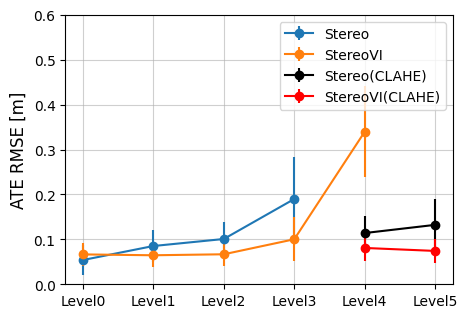

In [ ]:
plt.figure(figsize=(10, 3))

x_range1 = range(0,4)
x_range2 = range(0,5)
x_range3 = range(4,6)

plt.subplot(121)
plt.errorbar(x_range1, x_mono, yerr=e_mono, label='Mono', marker='o')
plt.errorbar(x_range2, x_monovi, yerr=e_monovi, marker='o', label='MonoVI')
plt.xticks([0, 1, 2, 3, 4, 5], [f'Level{i}' for i in range(6)])
plt.ylim(0, 0.6)
plt.grid(True, alpha=0.6)
plt.ylabel("ATE RMSE [m]", fontsize=12)
plt.legend(loc=0)

plt.subplot(122)
plt.errorbar(x_range1, x_stereo, yerr=e_stereo, marker='o', label='Stereo')
plt.errorbar(x_range2, x_stereovi, yerr=e_stereovi, marker='o', label='StereoVI')
# plt.errorbar(x_range3, x_stereo_clahe, yerr=e_stereo_clahe, marker='o', label='Stereo(CLAHE)', color='black')
# plt.errorbar(x_range3, x_stereovi_clahe, yerr=e_stereovi_clahe, marker='o', label='StereoVI(CLAHE)', color='red')
plt.xticks([0, 1, 2, 3, 4, 5], [f'Level{i}' for i in range(6)])
plt.ylim(0, 0.6)
plt.grid(True, alpha=0.6)
plt.legend(loc=0)

plt.show()